In [54]:
# import all libraries required 
import pandas as pd 
import numpy as np 
import os
import re
import string
import glob

from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt
import seaborn as sns
import hdbscan
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from bertopic import BERTopic


from sklearn.metrics import silhouette_score
import joblib

ModuleNotFoundError: No module named 'bertopic'

In [ ]:
!conda install -c conda-forge python=3.11

In [3]:
# Read the data from folder path 
def read_csv_from_folder(folder_path):

    # Find all CSV files in the specified folder
    csv_files = glob.glob(os.path.join(folder_path, '*.csv'))
    # List to store individual DataFrames
    df_list = []
    # Read each CSV file and append to the list
    for file in csv_files:
        df = pd.read_csv(file)
        df_list.append(df)

    # Combine all DataFrames into a single DataFrame
    combined_df = pd.concat(df_list, ignore_index=True)

    return combined_df

In [4]:
# Define the folder path where the CSV files are stored
folder_path = './data' # Replace with your specific folder path
df = read_csv_from_folder(folder_path)
print(df.head())

                                    Job Title  \
0                   Junior Endpoints Engineer   
1                             UX Writer - B2B   
2                    Treasury Risk Specialist   
3  Product Manager - Insurance - Policy Admin   
4              Account Executive - Manchester   

                                     Job Description  \
0  Booking.com\r\nIt wasn’t so long ago that book...   
1  At Booking.com, data drives our decisions. Tec...   
2  Booking.com’s global treasury team is looking ...   
3  About the company\r\nIt wasn’t so long ago tha...   
4  Account Executive - Bristol\r\nThis is a full ...   

                     Location                            Team  Job ID  
0  Manchester, United Kingdom                     Engineering     NaN  
1      Amsterdam, Netherlands        Design & User Experience     NaN  
2      Amsterdam, Netherlands                         Finance     NaN  
3  Manchester, United Kingdom                         Product     NaN  
4  Manch

In [5]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1311 entries, 0 to 1310
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Job Title        1311 non-null   object 
 1   Job Description  1311 non-null   object 
 2   Location         1311 non-null   object 
 3   Team             1311 non-null   object 
 4   Job ID           658 non-null    float64
dtypes: float64(1), object(4)
memory usage: 51.3+ KB
None


In [6]:
# Only take out job descriptions from above file 
df = pd.DataFrame(df['Job Description'])

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1311 entries, 0 to 1310
Data columns (total 1 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Job Description  1311 non-null   object
dtypes: object(1)
memory usage: 10.4+ KB


In [8]:
print(df['Job Description'].iloc[0:3])

0    Booking.com\r\nIt wasn’t so long ago that book...
1    At Booking.com, data drives our decisions. Tec...
2    Booking.com’s global treasury team is looking ...
Name: Job Description, dtype: object


Text Pre-Processing: observing the pattern in the job descriptions, i just see that there are charecters like /r and /n in few places which needs to be removed, but I also prefer to remove hyperlinks and urls in case if they are present for better semantic analysis, and will only lower the data first and then do all other stuff.

Note: I would not be removing stop words or do any kind of stemming or lemmitization, since i would be utilising a pre-trained models like sentence transformers, for generating the embeddings.

In [9]:
# Function to preprocess text
def preprocess_text(text):
    # Lowercasing
    text = text.lower()
    
    # Removing HTML tags
    text = re.sub(r'<.*?>', '', text)
    
    # Removing URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # Remove newline and carriage return characters
    text = text.replace('\n', ' ').replace('\r', ' ')

    # Replace Double spaces with a single space
    text = text.replace('  ', ' ')

    return text 

In [11]:
# Assuming your DataFrame is named df and the job descriptions are in a column named 'Job Description'
if 'Job Description' in df.columns:
    # Apply the preprocessing function to the 'Job Description' column
    df['Job Description - Cleaned'] = df['Job Description'].apply(preprocess_text)
    print(df[['Job Description', 'Job Description - Cleaned']].head())
else:
    print("The 'Job Description' column does not exist in the DataFrame.")

                                     Job Description  \
0  Booking.com\r\nIt wasn’t so long ago that book...   
1  At Booking.com, data drives our decisions. Tec...   
2  Booking.com’s global treasury team is looking ...   
3  About the company\r\nIt wasn’t so long ago tha...   
4  Account Executive - Bristol\r\nThis is a full ...   

                           Job Description - Cleaned  
0  booking.com it wasn’t so long ago that booking...  
1  at booking.com, data drives our decisions. tec...  
2  booking.com’s global treasury team is looking ...  
3  about the company it wasn’t so long ago that b...  
4  account executive - bristol this is a full tim...  


In [12]:
# Load the pre-trained sentence transformer model
embed_model_path = 'all-MiniLM-L6-v2'
embed_model = SentenceTransformer(embed_model_path)

# Compute embeddings for the job descriptions
df['minlm_Embeddings'] = df['Job Description - Cleaned'].apply(lambda x: embed_model.encode(x))

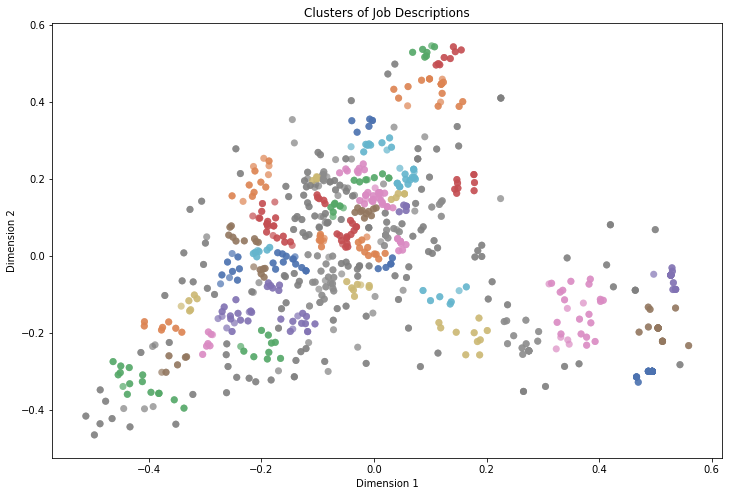

In [15]:
# Stack embeddings into a 2D array
embeddings = np.vstack(df['minlm_Embeddings'].values)


# Dimensionality reduction using PCA
def reduce_dimensions_pca(embeddings):
    pca = PCA(n_components=2)
    reduced_embeddings = pca.fit_transform(embeddings)
    return reduced_embeddings

# Apply PCA for dimensionality reduction
reduced_embeddings = reduce_dimensions_pca(embeddings)

# Clustering using HDBSCAN
clusterer = hdbscan.HDBSCAN(min_cluster_size=10, min_samples=1)
cluster_labels = clusterer.fit_predict(reduced_embeddings)

# Add cluster labels to DataFrame
df['Cluster'] = cluster_labels

# Visualization
def plot_clusters(reduced_embeddings, labels):
    plt.figure(figsize=(12, 8))
    palette = sns.color_palette('deep', np.unique(labels).max() + 1)
    colors = [palette[x] if x >= 0 else (0.5, 0.5, 0.5) for x in labels]
    
    plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=colors, s=50, linewidth=0, alpha=0.7)
    plt.title('Clusters of Job Descriptions')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.show()

plot_clusters(reduced_embeddings, cluster_labels)


There seems to be kind of around 7-8 natural clusters that are visible to naked eye, lets try to see what would elbow method in kmeans clustering will return us 

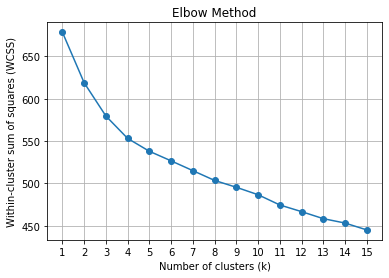

Optimal number of clusters (k): 2


In [17]:
# Convert the embeddings column to a NumPy array
embeddings = np.array(df['minlm_Embeddings'].tolist())

def find_optimal_k(data, max_k):
    wcss = []  # Within-cluster sum of squares

    # Calculate WCSS for different values of k
    for k in range(1, max_k + 1):
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(data)
        wcss.append(kmeans.inertia_)

    # Plot the Elbow Method graph
    plt.plot(range(1, max_k + 1), wcss, marker='o', linestyle='-')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Within-cluster sum of squares (WCSS)')
    plt.title('Elbow Method')
    plt.xticks(np.arange(1, max_k + 1))
    plt.grid(True)
    plt.show()

    # Find the optimal k (Elbow point)
    diff_wcss = np.diff(wcss, 2)
    optimal_k = np.argmax(diff_wcss) + 2  # Add 2 to account for zero-based indexing and diff operation
    return optimal_k

# Example usage

max_k = 15  # Maximum number of clusters to consider
optimal_k = find_optimal_k(embeddings, max_k)
print(f"Optimal number of clusters (k): {optimal_k}")


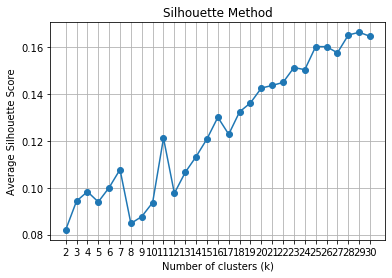

Optimal number of clusters (k): 29


In [23]:
# Let us also try out silhoute distance and try to anlyse the optimal clusters that can be formed. 
def find_optimal_k_silhouette(data, max_k):
    silhouette_scores = []

    # Calculate silhouette score for different values of k
    for k in range(2, max_k + 1):  # Silhouette score requires at least 2 clusters
        kmeans = KMeans(n_clusters=k)
        cluster_labels = kmeans.fit_predict(data)
        silhouette_avg = silhouette_score(data, cluster_labels)
        silhouette_scores.append(silhouette_avg)

    # Plot the Silhouette Method graph
    plt.plot(range(2, max_k + 1), silhouette_scores, marker='o', linestyle='-')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Average Silhouette Score')
    plt.title('Silhouette Method')
    plt.xticks(np.arange(2, max_k + 1))
    plt.grid(True)
    plt.show()

    # Find the optimal k (maximum silhouette score)
    optimal_k = np.argmax(silhouette_scores) + 2  # Add 2 to account for starting from 2 clusters
    return optimal_k


max_k = 30  # Maximum number of clusters to consider
optimal_k = find_optimal_k_silhouette(embeddings, max_k)
print(f"Optimal number of clusters (k): {optimal_k}")


In [35]:
print(embeddings)

[[-0.01359861 -0.0595836   0.0366937  ... -0.10991203 -0.02934936
   0.00802088]
 [-0.03453678 -0.09402989  0.0252269  ... -0.00544599 -0.01668082
  -0.00563807]
 [-0.03858706  0.05528273 -0.10405311 ... -0.10732228 -0.019417
   0.0521649 ]
 ...
 [ 0.0565293   0.00320823 -0.01362423 ... -0.07101266 -0.05438481
  -0.04145526]
 [ 0.01991465 -0.04819852 -0.03487677 ... -0.03181425 -0.05913744
   0.02687288]
 [ 0.04037369 -0.05786258 -0.05560314 ... -0.05730103 -0.0253719
   0.00733726]]


Even though silhoute score is incresing a lot after few iterations, i see that 16 could be the optimal value for clusters, since then the gain in avarage silhoute scores are very less, so i would train a k-means algorithm with 16 clusters and fit it to the data provided. 

[[-0.01359861 -0.0595836   0.0366937  ... -0.10991203 -0.02934936
   0.00802088]
 [-0.03453678 -0.09402989  0.0252269  ... -0.00544599 -0.01668082
  -0.00563807]
 [-0.03858706  0.05528273 -0.10405311 ... -0.10732228 -0.019417
   0.0521649 ]
 ...
 [ 0.0565293   0.00320823 -0.01362423 ... -0.07101266 -0.05438481
  -0.04145526]
 [ 0.01991465 -0.04819852 -0.03487677 ... -0.03181425 -0.05913744
   0.02687288]
 [ 0.04037369 -0.05786258 -0.05560314 ... -0.05730103 -0.0253719
   0.00733726]]


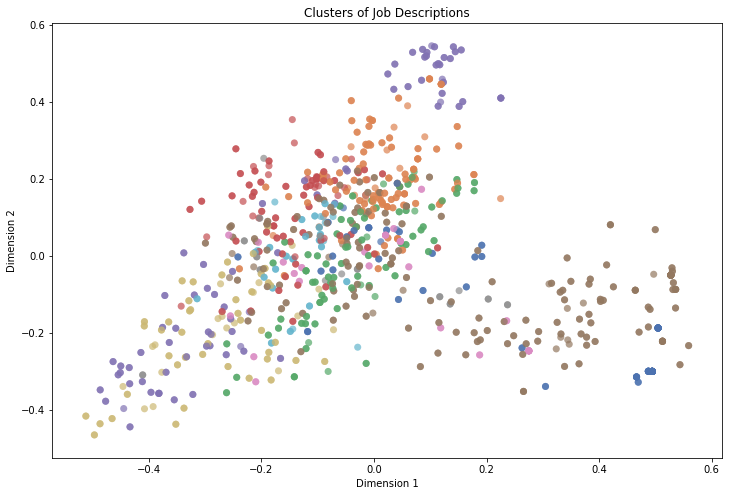

In [48]:
# Number of clusters
num_clusters = 16  # You can change this to the desired number of clusters

# Train K-means clustering model
kmeans = KMeans(n_clusters=num_clusters)
kmeans.fit(embeddings)
print(embeddings)

# Get cluster labels
cluster_labels = kmeans.labels_

# Add cluster labels to DataFrame
df['Cluster'] = cluster_labels


# Visualize the clusters
plot_clusters(reduced_embeddings, cluster_labels)

In [27]:
# save the model for further inference. 
# Save the trained K-means model to a file
model_filename = 'kmeans_model.sav'
joblib.dump(kmeans, model_filename)

['kmeans_model.sav']

In [28]:
df['Cluster'].value_counts()

13    174
10    157
1     156
14     85
5      78
7      72
2      67
8      67
4      65
0      63
12     61
15     60
6      57
3      56
11     51
9      42
Name: Cluster, dtype: int64

In [64]:
def inference(text, embed_model, kmeans_model):
    """
    Perform inference on the input text.

    Parameters:
    text (str): The input text to perform inference on.
    embed_model: The SentenceTransformer model for embedding.
    kmeans_model: The trained K-means clustering model.

    Returns:
    int: The cluster assigned to the input text.
    """
    # Preprocess text
    preprocessed_text = preprocess_text(text)
    
    # Embed preprocessed text
    embedding = embed_model.encode(preprocessed_text)
    
    # Predict cluster using K-means model
    cluster_label = kmeans_model.predict(embedding.reshape(-1, 384))
    
    return cluster_label

In [65]:
# Load the saved K-means model
kmeans_loaded = joblib.load('kmeans_model.sav')

# Assuming you have a SentenceTransformer model stored in `model`
# Now, perform inference on a new text
text = """At Booking.com, we are seeking a highly skilled and motivated Data Scientist to join our Data Science team in Amsterdam. As a Data Scientist, you will play a crucial role in driving data-driven decision-making across our organization, leveraging cutting-edge 
techniques to extract insights from large datasets and drive\n\r business growth.

http://www.google.com
Responsibilities:

Utilize advanced statistical and machine learning techniques to analyze large-scale data sets and derive actionable insights.
Develop predictive models and algorithms to optimize various aspects of our platform, including user experience, pricing, and demand forecasting.
Collaborate closely with cross-functional teams, including Product, Engineering, and Marketing, to identify opportunities for leveraging data to improve business outcomes.
Design and implement experiments to measure the impact of new features and initiatives.
Communicate findings and recommendations to stakeholders in a clear and actionable manner."""

pred_cluster = inference(text, embed_model, kmeans_loaded)

print("This Above text entered belongs to cluster:",pred_cluster)


This Above text entered belongs to cluster: [6]


In [61]:
infer_cleaned = preprocess_text(text)

print(infer_cleaned)
# convert cleaned text to embeddings
infer_embeddings = embed_model.encode(infer_cleaned)
print(infer_embeddings)

at booking.com, we are seeking a highly skilled and motivated data scientist to join our data science team in amsterdam. as a data scientist, you will play a crucial role in driving data-driven decision-making across our organization, leveraging cutting-edge techniques to extract insights from large datasets and drive  business growth.  responsibilities: utilize advanced statistical and machine learning techniques to analyze large-scale data sets and derive actionable insights. develop predictive models and algorithms to optimize various aspects of our platform, including user experience, pricing, and demand forecasting. collaborate closely with cross-functional teams, including product, engineering, and marketing, to identify opportunities for leveraging data to improve business outcomes. design and implement experiments to measure the impact of new features and initiatives. communicate findings and recommendations to stakeholders in a clear and actionable manner.
[ 3.20075303e-02 -1.

In [63]:
# Predict cluster using K-means model
cluster_label = kmeans_loaded.predict(infer_embeddings.reshape(-1, 384))
print(cluster_label)

[6]


In [57]:
embeddings_2d = df.minlm_Embeddings[0].reshape(-1, 384)
kmeans.predict(embeddings_2d)

array([15])

In [58]:
df.head()

,Job Description,Job Description - Cleaned,minlm_Embeddings,Cluster
0,Booking.com\r\nIt wasn’t so long ago that book...,booking.com it wasn’t so long ago that booking...,"[-0.013598608, -0.059583597, 0.0366937, -0.022...",15
1,"At Booking.com, data drives our decisions. Tec...","at booking.com, data drives our decisions. tec...","[-0.034536783, -0.09402989, 0.025226902, 0.042...",2
2,Booking.com’s global treasury team is looking ...,booking.com’s global treasury team is looking ...,"[-0.038587064, 0.055282734, -0.10405311, 0.013...",14
3,About the company\r\nIt wasn’t so long ago tha...,about the company it wasn’t so long ago that b...,"[-0.0008498117, 0.023763949, 0.012399482, 0.00...",15
4,Account Executive - Bristol\r\nThis is a full ...,account executive - bristol this is a full tim...,"[0.042453874, -0.041009426, 0.06616306, -0.040...",10


In [66]:
df.to_csv("df_with_clusters.csv")